In [874]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import UnivariateSpline
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [875]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

In [876]:
def visualize_data(data, features):
    for feature in features:
        plt.figure(figsize=(10, 4))

        # Boxplot for outlier detection
        plt.subplot(1, 2, 1)
        sns.boxplot(data[feature])
        plt.title(f'Boxplot of {feature}')

        # Histogram for distribution
        plt.subplot(1, 2, 2)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        plt.show()

In [877]:
def plot_residuals(residuals, y_pred):
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

In [878]:
def normality(residuals):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.show()

In [879]:
def preprocess_data(data, features, imputer):
    data[features] = imputer.transform(data[features])
    return data

In [880]:
def train_model_statsmodels(X, y):
    X = sm.add_constant(X)  # Adding a constant to the model
    model = sm.OLS(y, X).fit(cov_type='HC0')
    return model

In [881]:
def train_model_randomforest(X, y):
    random_forest = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, random_state=1234)
    model = random_forest.fit(X, y)
    return model

In [882]:
def train_model_xgboost(X, y):
    xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
    model = xgb_test.fit(X, y)
    return model

In [883]:
def generate_polynomials(data):
    poly = PolynomialFeatures(degree=2, include_bias=True)
    data = poly.fit_transform(data)

    #feature_names = poly.get_feature_names_out()
    #data = pd.DataFrame(data, columns=feature_names)
    return data

In [884]:
def create_k_folds(df, fold_n=5):
    folds = {}
    fold_size = len(df) // fold_n
    for i in range(fold_n):
        start = i * fold_size
        if i == fold_n - 1:  # In the last fold, include all remaining data
            end = len(df)
        else:
            end = start + fold_size
        folds[i] = df[start:end]
    return folds

In [885]:
def find_index(lst, target):
    for i, number in enumerate(lst):
        if number == target:
            return i
    return None

In [886]:
def train_final_model(folds_X, folds_y):
    cv_amount = len(folds_X)
    models, r2_scores, rmse_scores, predictions = {}, {}, {}, {}
    r2_total = 0
    rmse_total = 0
    
    for i in range(cv_amount):
        test_X, test_y = folds_X[i], folds_y[i]
        train_X = np.concatenate([folds_X[n] for n in range(len(folds_X)) if n != i])
        train_y = np.concatenate([folds_y[n] for n in range(len(folds_y)) if n != i])
        
        models['model_{}'.format(i)] = train_model_statsmodels(train_X, train_y)   # Train the model
        test_X = sm.add_constant(test_X)                                           # Adding a constant to the validation data
        y_pred_log = models['model_{}'.format(i)].predict(test_X)                  # Predicted log-transformed prices
        y_pred = np.expm1(y_pred_log)                                              # Inverse transformation
        predictions[i] = y_pred                                                    # Saving the predictions for residual analysis

        r2_scores[i] = r2_score(np.expm1(test_y), y_pred)
        r2_total += r2_score(np.expm1(test_y), y_pred)

        rmse_scores[i] = mean_squared_error(test_y, y_pred_log, squared=False)
        rmse_total += rmse_scores[i]

    # Final model and the final model's score
    r2_average = r2_total / cv_amount
    rmse_average = rmse_total / cv_amount
    r2_list = []
    for i in range(len(r2_scores)):
        r2_list.append(r2_scores[i])
    max_r2 = max(r2_list)
    min_r2 = min(r2_list)
    index_max_r2 = find_index(r2_list, max_r2)
    index_min_r2 = find_index(r2_list, min_r2)
    final_model = models['model_{}'.format(index_max_r2)]
    
    # Residual analysis
    residuals_cv = np.expm1(folds_y[index_min_r2]) - predictions[index_min_r2]
    plot_residuals(residuals_cv, predictions[index_min_r2])
    normality(residuals_cv)
    #print(residuals_cv.sort_values())
    
    #print("All R-squared score:  ", r2_scores)
    print("Average R-squared score:  ", r2_average)
    print("Max R-squared score:  ", r2_scores[index_max_r2], index_max_r2)
    print("Min R-squared score:  ", r2_scores[index_min_r2], index_min_r2)
    print("Average RMSE score:  ", rmse_average)
    return final_model, rmse_average

In [887]:
def select_features(X, y, top=100):
    lasso = Lasso(alpha =0.05, random_state=1)
    lasso.fit(X, y)
    
    weights = lasso.coef_
    top = min(len(weights), top)
    
    threshold = np.sort(np.abs(weights))[-top]
    
    # Identify columns with weight below 0.5
    columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= threshold]

    # Delete these columns from X
    X = X.drop(columns=columns_to_delete)
    return X.columns

In [888]:
ordinal_mapping = {
    'Ex': 5,  # Excellent
    'Gd': 4,  # Good
    'TA': 3,  # Average/Typical
    'Fa': 2,  # Fair
    'Po': 1,  # Poor
    'NA': 0,  # None

    'Gtl':3,  # Gentle slope
    'Mod':2,  # Moderate Slope	
    'Sev':1   # Severe Slope
}
def data_mapping(train_data, test_data, column, mapping=ordinal_mapping):
    train_data[column] = train_data[column].map(mapping)
    test_data[column] = test_data[column].map(mapping)
    return train_data[column], test_data[column]

In [889]:
# Paths to the datasets
train_path = 'train.csv'
test_path = 'test.csv'

# Load the data
train_data, test_data = load_data(train_path, test_path)
train_data.drop([523, 691, 898, 1324], inplace=True)
#train_data.drop([88,462,523,588,632,968,1298,1324], inplace=True)

original_train = pd.read_csv(train_path)
original_test = pd.read_csv(test_path)

data_mapping(train_data, test_data, 'KitchenQual')
data_mapping(train_data, test_data, 'HeatingQC')
data_mapping(train_data, test_data, 'Electrical')

data_mapping(original_train, original_test, 'KitchenQual')
data_mapping(original_train, original_test, 'HeatingQC')
data_mapping(original_train, original_test, 'Electrical')
             
#convert categorical variable into dummy
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

original_train = pd.get_dummies(original_train)
original_test = pd.get_dummies(original_test)

# Visualize data
selected_features = ['HeatingQC', 'MasVnrArea', 'KitchenQual', 'SaleCondition_Normal', 
                     'ExterQual_TA', 'LotArea', 'BsmtQual_Ex', 'Electrical',
                     'YrSold', 'OverallQual', 'OverallCond', 'GrLivArea', 'TotalBsmtSF', 
                     'GarageCars', 'MSSubClass', 'YearBuilt']
#visualize_data(train_data, selected_features)

In [890]:
# Handling missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
train_data[selected_features] = imputer.fit_transform(train_data[selected_features])
original_train[selected_features] = imputer.fit_transform(original_train[selected_features])

# Preprocessing the test data
test_data = preprocess_data(test_data, selected_features, imputer)

# Apply log transformation to the target variable 'SalePrice'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
original_train['SalePrice'] = np.log1p(original_train['SalePrice'])

y = train_data['SalePrice']
X = train_data[selected_features]

y_original = train_data['SalePrice']
X_original = train_data[selected_features]

X_poly = generate_polynomials(X)
X_test = generate_polynomials(test_data[selected_features])

X_poly_original = generate_polynomials(X_original)

#X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.1, random_state=0)

folds_X = create_k_folds(X_poly, fold_n=8)
folds_y = create_k_folds(y, fold_n=8)

'''
X_poly = generate_polynomials(X_poly)
X_test = generate_polynomials(X_test)

selected_features_lasso = select_features(X_poly, y, top=100)

X_poly = X_poly[selected_features_lasso]
X_test = X_test[selected_features_lasso]
'''

'\nX_poly = generate_polynomials(X_poly)\nX_test = generate_polynomials(X_test)\n\nselected_features_lasso = select_features(X_poly, y, top=100)\n\nX_poly = X_poly[selected_features_lasso]\nX_test = X_test[selected_features_lasso]\n'

In [891]:
'''
model = RandomForestRegressor(n_jobs = -1) 
params = {'max_depth': [20,30,40], 'n_estimators': [500], 'max_features': [100,140,160]} 
gsCV = GridSearchCV(estimator = rf_test, param_grid = params, cv = 5, n_jobs = -1, verbose = 3) 
gsCV.fit(train_data.drop('SalePrice',axis = 1),train_data['SalePrice'])
print(gsCV.best_estimator_)
'''

"\nmodel = RandomForestRegressor(n_jobs = -1) \nparams = {'max_depth': [20,30,40], 'n_estimators': [500], 'max_features': [100,140,160]} \ngsCV = GridSearchCV(estimator = rf_test, param_grid = params, cv = 5, n_jobs = -1, verbose = 3) \ngsCV.fit(train_data.drop('SalePrice',axis = 1),train_data['SalePrice'])\nprint(gsCV.best_estimator_)\n"

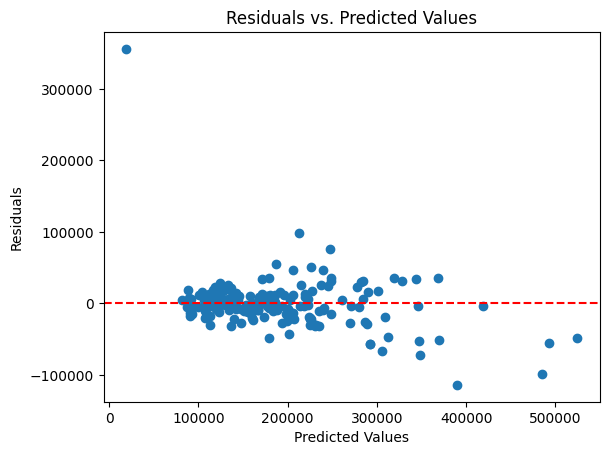

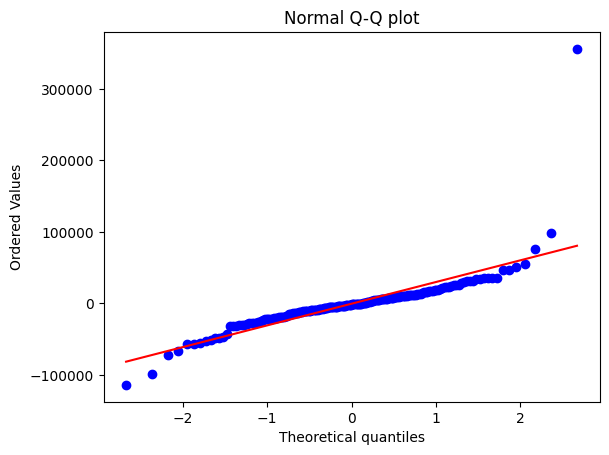

Average R-squared score:   0.8553714726638315
Max R-squared score:   0.9260575863685514 6
Min R-squared score:   0.7725455075008432 1
Average RMSE score:   0.15349881623780154


In [892]:
# Training the model using cross-validation
final_model, rmse_average = train_final_model(folds_X, folds_y)

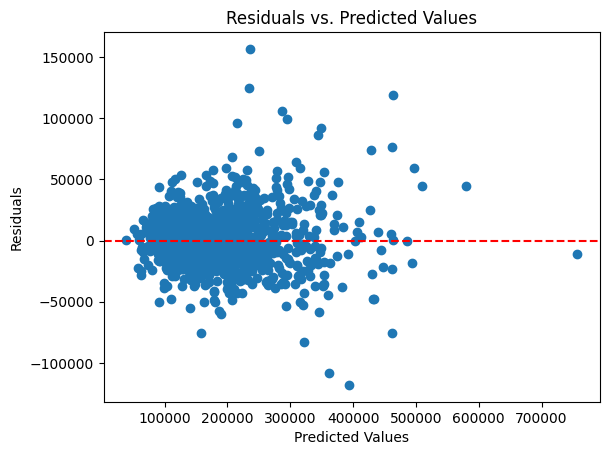

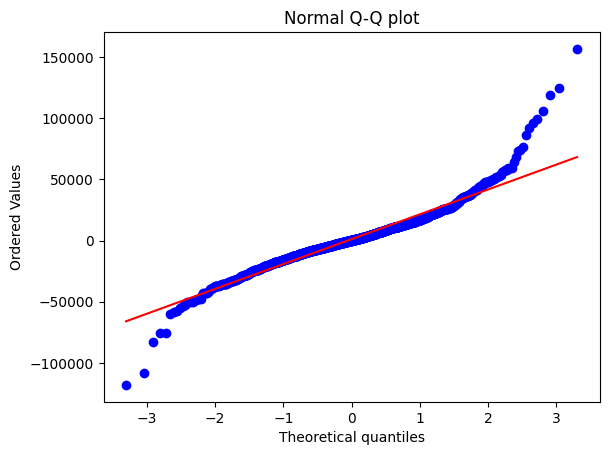

R-squared value: 0.9259659184585648
RMSE 0.11634500103872047


In [893]:
# Training the model
model = train_model_statsmodels(X_poly, y)

# Evaluating the model
X_poly = sm.add_constant(X_poly_original)  # Adding a constant to the validation data
y_pred_log =model.predict(X_poly)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y_original), y_pred)
rmse_score = mean_squared_error(y_original, y_pred_log, squared=False)
residuals = np.expm1(y_original) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)
print("RMSE", rmse_score)

In [894]:
(rmse_score + rmse_average) / 2

0.134921908638261

In [895]:
'''
weights = lasso.coef_
plt.hist(weights, bins=50, log=True)

# Identify columns with weight below 0.5
columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]

# Delete these columns from X
X_filtered = X_poly.drop(columns=columns_to_delete)
X_filtered_test = X_test.drop(columns=columns_to_delete)
X_filtered_test
'''

'\nweights = lasso.coef_\nplt.hist(weights, bins=50, log=True)\n\n# Identify columns with weight below 0.5\ncolumns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]\n\n# Delete these columns from X\nX_filtered = X_poly.drop(columns=columns_to_delete)\nX_filtered_test = X_test.drop(columns=columns_to_delete)\nX_filtered_test\n'

In [896]:
'''
model = train_model_statsmodels(X_filtered, y_train)

# Evaluating the model
X_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data
y_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y), y_pred)
residuals = np.expm1(y) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)
'''

'\nmodel = train_model_statsmodels(X_filtered, y_train)\n\n# Evaluating the model\nX_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data\ny_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices\ny_pred = np.expm1(y_pred_log)  # Inverse transformation\nr_squared = r2_score(np.expm1(y), y_pred)\nresiduals = np.expm1(y) - y_pred\nplot_residuals(residuals, y_pred)\nnormality(residuals)\nprint("R-squared value:", r_squared)\n'

In [897]:
# Predicting the housing prices for the test data
X_test = sm.add_constant(X_test)  # Adding a constant to the test data
predicted_log_prices = model.predict(X_test)  # Predicted log-transformed prices for test data
predicted_prices = np.expm1(predicted_log_prices)  # Inverse transformation for test data predictions

In [898]:
''
# Saving the predictions
predicted_prices_df = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': predicted_prices
})
predicted_prices_df.to_csv('predicted_housing_prices_statsmodels.csv', index=False)
''

''

In [899]:
train_data.columns.tolist()

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',


In [900]:
error = np.expm1(y) - y_pred
error = np.abs(error)
error_ascending = error.sort_values()
train_data['error'] = error
train_data.sort_values(by='error')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,error
519,520,70.0,53.0,10918.0,7.0,...,False,False,1.0,False,5.135016
849,850,80.0,80.0,9600.0,6.0,...,False,False,1.0,False,57.260362
1264,1265,120.0,34.0,4060.0,6.0,...,False,False,0.0,False,57.607386
1308,1309,20.0,100.0,12000.0,5.0,...,False,False,1.0,False,58.955371
466,467,20.0,85.0,10628.0,7.0,...,False,False,1.0,False,62.580304
...,...,...,...,...,...,...,...,...,...,...,...
581,582,20.0,98.0,12704.0,8.0,...,False,False,0.0,True,108365.096258
261,262,60.0,69.0,9588.0,8.0,...,False,False,0.0,True,117954.648420
803,804,60.0,107.0,13891.0,9.0,...,False,False,0.0,True,119064.045155
608,609,70.0,78.0,12168.0,8.0,...,True,False,0.0,False,124248.681094


In [901]:
train_merged = pd.merge(original_train, train_data[['Id', 'error']], on='Id')
train_merged

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,error
0,1,60.0,65.0,8450.0,7.0,...,False,False,1.0,False,4528.725872
1,2,20.0,80.0,9600.0,6.0,...,False,False,1.0,False,240.699853
2,3,60.0,68.0,11250.0,7.0,...,False,False,1.0,False,10661.068531
3,4,70.0,60.0,9550.0,7.0,...,False,False,0.0,False,14955.075441
4,5,60.0,84.0,14260.0,8.0,...,False,False,1.0,False,35291.279142
...,...,...,...,...,...,...,...,...,...,...,...
1451,1456,60.0,62.0,7917.0,6.0,...,False,False,1.0,False,7335.242212
1452,1457,20.0,85.0,13175.0,6.0,...,False,False,1.0,False,615.486786
1453,1458,70.0,66.0,9042.0,7.0,...,False,False,1.0,False,25993.015855
1454,1459,20.0,68.0,9717.0,5.0,...,False,False,1.0,False,14871.172630


In [902]:
train_merged.sort_values(by='error')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,error
519,520,70.0,53.0,10918.0,7.0,...,False,False,1.0,False,5.135016
847,850,80.0,80.0,9600.0,6.0,...,False,False,1.0,False,57.260362
1261,1265,120.0,34.0,4060.0,6.0,...,False,False,0.0,False,57.607386
1305,1309,20.0,100.0,12000.0,5.0,...,False,False,1.0,False,58.955371
466,467,20.0,85.0,10628.0,7.0,...,False,False,1.0,False,62.580304
...,...,...,...,...,...,...,...,...,...,...,...
580,582,20.0,98.0,12704.0,8.0,...,False,False,0.0,True,108365.096258
261,262,60.0,69.0,9588.0,8.0,...,False,False,0.0,True,117954.648420
801,804,60.0,107.0,13891.0,9.0,...,False,False,0.0,True,119064.045155
607,609,70.0,78.0,12168.0,8.0,...,True,False,0.0,False,124248.681094


In [903]:
correlations = pd.get_dummies(train_merged).astype(np.float64).corrwith(train_merged['error'])
correlations.sort_values().tail(50)

C:\Users\mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Exterior1st_CemntBd      0.081596
SaleCondition_Alloca     0.087903
RoofMatl_Tar&Grv         0.097236
YearBuilt                0.097774
Neighborhood_NoRidge     0.099971
GarageYrBlt              0.102615
LotShape_IR1             0.103482
RoofStyle_Hip            0.104124
HeatingQC                0.108126
Exterior1st_BrkFace      0.108618
LandSlope_Mod            0.110656
RoofStyle_Flat           0.111125
OpenPorchSF              0.114739
FireplaceQu_Ex           0.116093
WoodDeckSF               0.117024
2ndFlrSF                 0.118055
GarageFinish_Fin         0.118127
BsmtFinSF1               0.125288
MasVnrType_Stone         0.126878
BsmtFinType1_GLQ         0.130662
Neighborhood_StoneBr     0.134359
LotArea                  0.137550
BsmtUnfSF                0.140765
LotFrontage              0.141936
Foundation_PConc         0.144421
Neighborhood_NridgHt     0.146594
YearRemodAdd             0.147090
ExterQual_Ex             0.157989
LandContour_HLS          0.162161
ExterQual_Gd  